In [68]:

from surprise import SVD, SVDpp
from surprise import Dataset, NormalPredictor
from surprise.model_selection import cross_validate
import pandas as pd
from sklearn.decomposition import NMF
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error
from surprise import Reader
from surprise.model_selection import GridSearchCV

# Завантажити movielens-100k dataset (download it if needed).
# data_suprise = Dataset.load_builtin('ml-100k')
# data = pd.DataFrame(data_suprise.__dict__['raw_ratings'], columns=['user_id','item_id','rating','timestamp'])
# data.head()

In [69]:
data_csv = pd.read_csv('ml-latest-small/ratings.csv', low_memory=False)
data_csv.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
reader = Reader(line_format='user item rating timestamp', sep=',', rating_scale=(1, 5))
data_suprise = Dataset.load_from_df(data_csv[['userId', 'movieId', 'rating']], reader=reader)

In [4]:
cross_validate(NormalPredictor(), data_suprise, cv=2)

{'test_rmse': array([1.41933239, 1.42221734]),
 'test_mae': array([1.13485196, 1.1366613 ]),
 'fit_time': (0.14500117301940918, 0.13199806213378906),
 'test_time': (0.7062115669250488, 0.6941678524017334)}

In [42]:
# Створення моделі SVD
rank = 5
model_SVD = SVD(n_factors=100, n_epochs=20, lr_all=0.005, reg_all=0.02)

In [43]:
results_SVD = cross_validate(model_SVD, data_suprise, measures=['RMSE', 'MAE'], cv=rank, verbose=True)
results_SVD

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8680  0.8727  0.8802  0.8753  0.8734  0.8739  0.0040  
MAE (testset)     0.6657  0.6713  0.6770  0.6749  0.6704  0.6718  0.0039  
Fit time          1.00    1.04    1.01    1.02    1.03    1.02    0.01    
Test time         0.10    0.20    0.10    0.10    0.20    0.14    0.05    


{'test_rmse': array([0.86796478, 0.87271841, 0.88021994, 0.87533561, 0.87343047]),
 'test_mae': array([0.66568618, 0.67127016, 0.6769504 , 0.67486542, 0.67038301]),
 'fit_time': (1.0011684894561768,
  1.0389437675476074,
  1.0137386322021484,
  1.0208492279052734,
  1.0265605449676514),
 'test_time': (0.09600591659545898,
  0.20278477668762207,
  0.10119891166687012,
  0.09905004501342773,
  0.2019214630126953)}

In [48]:
# results_SVD['test_rmse'].mean()

In [7]:
# Створення моделі SVD++
model_SVDpp = SVDpp(n_factors=20, n_epochs=20, lr_all=0.007, reg_all=0.02)
results_SVDpp = cross_validate(model_SVDpp, data_suprise, measures=['RMSE', 'MAE'], cv=5, verbose=True)
results_SVDpp

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8630  0.8554  0.8656  0.8531  0.8666  0.8607  0.0055  
MAE (testset)     0.6615  0.6572  0.6642  0.6542  0.6639  0.6602  0.0039  
Fit time          256.48  260.43  261.09  263.88  260.00  260.38  2.37    
Test time         26.75   26.68   26.30   26.83   26.70   26.65   0.18    


{'test_rmse': array([0.86300105, 0.85540807, 0.86564031, 0.85307799, 0.8665593 ]),
 'test_mae': array([0.66152921, 0.65721192, 0.6641546 , 0.65417075, 0.66391434]),
 'fit_time': (256.4776825904846,
  260.43215918540955,
  261.0922038555145,
  263.8838930130005,
  259.9977648258209),
 'test_time': (26.748462438583374,
  26.675405740737915,
  26.304062604904175,
  26.83409881591797,
  26.698894023895264)}

In [14]:
data = data_csv[['userId', 'movieId', 'rating']]

In [83]:
rank = 9
model = NMF(n_components=rank, init='random', random_state=0, max_iter=500)
W = model.fit_transform(data)
H = model.components_
# V = W @ H 
V = pd.DataFrame(np.dot(W,H), columns=data.columns)
V

C:\Users\user\anaconda3\Lib\site-packages\sklearn\decomposition\_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


,userId,movieId,rating
0,1.066492,1.004244,0.018901
1,1.066441,3.004242,0.021033
2,1.066363,6.004239,0.024230
3,1.082304,47.005279,0.056657
4,1.082252,50.005277,0.058814
...,...,...,...
100831,609.956248,166533.997214,6.130314
100832,609.966077,168247.998266,6.182121
100833,609.964749,168249.998098,6.322139
100834,609.964746,168251.998099,6.309844


In [58]:
RMSE_NMF = np.sqrt(mean_squared_error(data, V))
RMSE_NMF

1.0003213413165843

In [84]:
МАE_NMF = mean_absolute_error(data, V)
МАE_NMF

0.4747962693657107

In [71]:
from surprise import accuracy
from surprise.model_selection import train_test_split

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_suprise, test_size=0.25)

# We'll use the famous SVD algorithm.
algo = SVD()

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.8783


0.8782866589961893

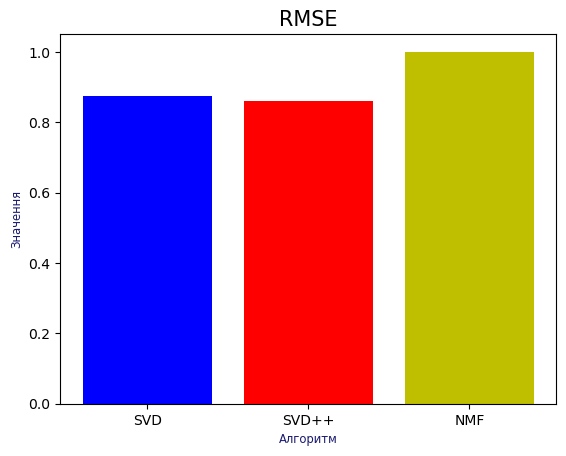

In [72]:
import matplotlib.pyplot as plt

plt.bar(
    ["SVD", "SVD++", "NMF"],
    [results_SVD['test_rmse'].mean(), results_SVDpp['test_rmse'].mean(), RMSE_NMF],
    color=["b", "r", "y", "g"],
)

plt.xlabel("Алгоритм", fontsize="small", color="midnightblue")
plt.ylabel("Значення", fontsize="small", color="midnightblue")
plt.title("RMSE", fontsize=15)
plt.show()

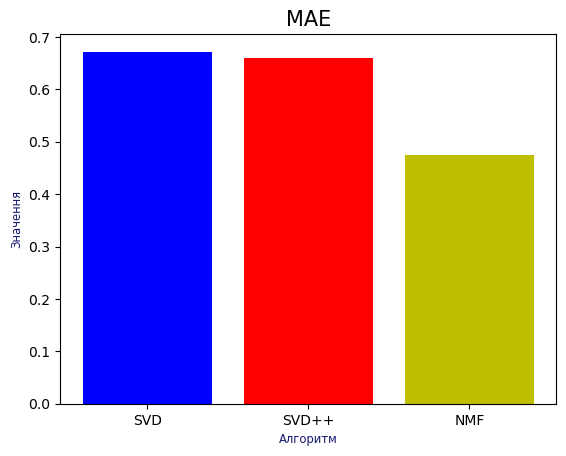

In [76]:
import matplotlib.pyplot as plt

plt.bar(
    ["SVD", "SVD++", "NMF"],
    [results_SVD['test_mae'].mean(), results_SVDpp['test_mae'].mean(), МАE_NMF],
    color=["b", "r", "y", "g"],
)

plt.xlabel("Алгоритм", fontsize="small", color="midnightblue")
plt.ylabel("Значення", fontsize="small", color="midnightblue")
plt.title("MAE", fontsize=15)
plt.show()